In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.datasets import load_diabetes
from   sklearn.preprocessing import StandardScaler

from   causal_inference import CausalInference

In [2]:
HOME = os.environ['HOME']
DATA = (f'{HOME}/repos/research/marketing/marketing_eda/'
        'marketing_model_program/2021/data')
data = pd.read_csv(f'{DATA}/marketing_dataset_ran_2021-03-18.csv')
#data = pd.read_csv(
#    f'{HOME}/Downloads/marketing_dataset_ran_2021-03-05.csv')
data.day = pd.to_datetime(data.day)
data.index = data.day
data['day_of_month'] = data.index.day.astype(int)
data['day_of_year'] = data.index.dayofyear.astype(int)
data.drop('day', axis=1, inplace=True)
data.shape

(2588, 162)

In [3]:
data.head()

,spiceworks_imp,neudesic_imp,neudesic_clicks,magnetic_imp,magnetic_clicks,triple_imp,triple_clicks,triple_cost,tubemogul_imp,tubemogul_clicks,...,MAdcm_td_cost,MAdcm_td_clicks,MAdcm_iq_imp,MAdcm_iq_clicks,MAdcm_iq_cost,MAquantcast_cost,MAquantcast_imp,MAquantcast_clicks,day_of_month,day_of_year
day,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2014-01-02,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2014-01-03,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
2014-01-04,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
2014-01-05,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5


In [4]:
costs = [col for col in list(data) 
         if col.endswith('_cost') and col != 'ann_cost']
ma = [col for col in list(data) if col.startswith('MA')]
OMISSIBLE = [
    'fed_rate', 'money_velocity', 'retail_sales', 'saving_rate', 
    'fb_posts', 'youtube_net_subscribers', 'youtube_min_watched', 
    'featured_vids', 'new_licenses'
] + costs + ma
for om in OMISSIBLE:
    assert om in list(data), f'{om} not a valid column name'
data.drop(OMISSIBLE, axis=1, inplace=True)

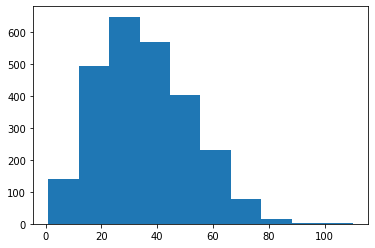

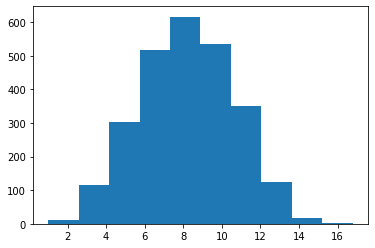

In [5]:
plt.hist(data.new_accounts)
plt.figure()
plt.hist(data.new_accounts ** 0.6);

In [6]:
#list(data)

In [7]:
scaler = StandardScaler()

# NOTE: scaling in the CausalInference class will NOT be applied to your 
# response, so if you wish to transform it, do it first:
transform_response = lambda x: x ** 0.6
revert_response = lambda x: x ** (1 / 0.6)
data.new_accounts = data.new_accounts.apply(transform_response)

# Determine which columns are to be treated as `response`, `treatment`, 
# and `covariates`
response_var = 'new_accounts'
# e.g., we want to know if bing_brand_clicks has a causal effect on 
# purchases
treatment_var = 'bing_brand_clicks' 
# All other fields will be used as covariates by default, but you can
# specify a smaller subset, e.g.,
covariates = ['tw_paid_engagements', 'organic_brand_clicks', 'ann_cost']

### Example 1: Binary Treatment Variable

In [8]:
causal_inf = CausalInference(data, 
                             response_var, 
                             treatment_var, 
                             covariates=covariates,
                             force_binary=True,
                             scaler=scaler)

In [9]:
causal_inf.treatment_type

'binary'

In [10]:
causal_inf.get_propensity_scores(forward_folds=True)

Searching for optimal L2 penalty with:
C = 0.00010
New best-- loss: 18.6204841144791
C = 0.00016
New best-- loss: 18.597751227418136
C = 0.00026
C = 0.00043
New best-- loss: 18.575018340357175
C = 0.00070
C = 0.00113
C = 0.00183
C = 0.00298
New best-- loss: 18.552285453296207
C = 0.00483
C = 0.00785
C = 0.01274
C = 0.02069
New best-- loss: 18.544133953288842
C = 0.03360
New best-- loss: 18.529551891080494
C = 0.05456
New best-- loss: 18.47765487960283
C = 0.08859
New best-- loss: 18.16328041079753
C = 0.14384
New best-- loss: 17.973713602089003
C = 0.23357
New best-- loss: 17.798728855588827
C = 0.37927
New best-- loss: 17.725818544547085
C = 0.61585
New best-- loss: 17.594579984671952
C = 1.00000
New best-- loss: 17.55083379804691
Refitting best model on all data...


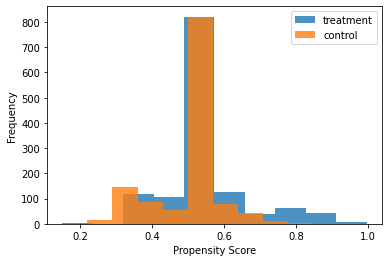

In [12]:
causal_inf.plot_propensity_scores()

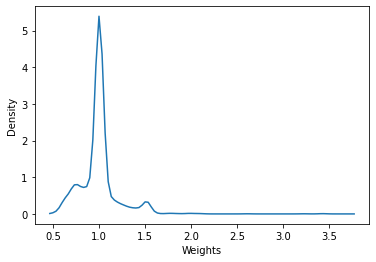

In [13]:
# Get IPTW (inverse probability of treatment weighting) to attempt to 
# balance the distribution. Plot to see that no indivduals are getting 
# unreasonably large weights (as a rule of thumb <= 20 ok).  If getting
# large weights, consider using the `trunc_q` or `trunc_val` args.
causal_inf.get_iptw(plot=True)

In [14]:
smd_table = causal_inf.assess_balance()
smd_table
# smds <= 0.1 are ideal; < 0.2 are "acceptable" (there is no guarantee 
# that) you will be able to balance if there is little to no overlap in
# control/treated distributions... but here, all is well :)

,mean_treat,mean_contr,smd,mean_treat_weighted,mean_contr_weighted,smd_weighted
organic_brand_clicks,0.074445,-0.078220,0.153448,-0.021328,-0.031923,0.010670
ann_cost,0.029870,-0.031385,0.061216,0.015412,-0.000626,0.016112
tw_paid_engagements,0.059575,-0.062596,0.123818,-0.000193,-0.048173,0.064587


In [15]:
# Marginal Structural Model: 
# What you care most about here is if our coefficient for treatment is 
# significantly different from 0.  The point estimate is given under 
# `coef` in the table, and the probability, by `P<|t|`, which is "0.000"
# here or < 0.0005.  But, the standard WLS summary provided by statsmodels
# does not correct for SE being error due to weighting.  Hence, the final
# output is a table, with the coefficents, and their confidence interval.
# If 0 is not included in the interval, then the treatment is significant
# at the given alpha (0.05 by default; 95% CI), given the model
causal_inf.run_msm(verbose=True)

                            WLS Regression Results                            
Dep. Variable:           new_accounts   R-squared:                       0.107
Model:                            WLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     309.6
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           1.53e-65
Time:                        11:48:03   Log-Likelihood:                -5880.4
No. Observations:                2588   AIC:                         1.176e+04
Df Residuals:                    2586   BIC:                         1.178e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             7.4325      0.06

In [16]:
# You can adjust alpha (and hence CI = 1 - alpha) to whatever level you 
# like
causal_inf.run_msm(alpha=0.001)

99.9% confidence interval for coefficients after SE correction:
                      lower       est     upper
intercept          7.177064  7.432475  7.687886
bing_brand_clicks  1.294587  1.609553  1.924520


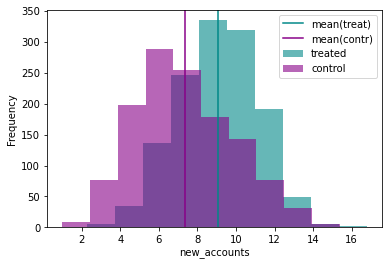


Shapiro-Wilk test for normality in "treatment"
p=0.01297; Deviates significantly from normality at alpha=0.05.

Shapiro-Wilk test for normality in "control"
p=0.00000; Deviates significantly from normality at alpha=0.05.

F test for equal variances
p=0.00000; Distributions  differ significantly


T-test indicates means are significantly different (p=0.00000)
Observed difference (treat - contr): 1.6864303250289758


1.6864303250289758

In [17]:
# T-test
causal_inf.t_test()

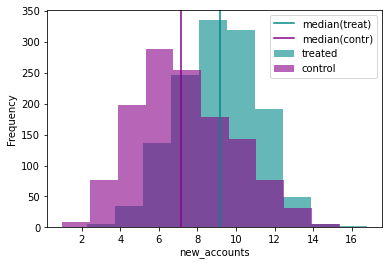


Mann-Whitney U-test indicates medians are significantly different (p=0.00000)
Observed difference (treat - contr):  2.002306274001066


2.002306274001066

In [18]:
# Mann-Whitney U-Test
causal_inf.mann_whitney_test()

In [19]:
# Bootstrap an aribitrary statistic.  For example: medians are different, 
# but what about an arbitrary quantile?  Do the 75th percentiles differ
# significantly?
def get_quantile_diff(contr, treat, q):
    q_treat = treat.quantile(q=q)
    q_contr = contr.quantile(q=q)
    diff = q_treat - q_contr
    return diff

N observed: 2588
Control: 1262; Treated: 1326
Observed statistic: 1.5731595538129373
Done!                                                   


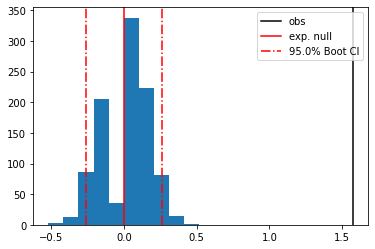

lower bound: -0.2594760467874888
expected   : 0.0
upper bound: 0.2594760467874888


In [20]:
stats, obs_stat = causal_inf.bootstrap(
    get_quantile_diff, verbose=True, q=0.75)

N observed: 2588
Control: 1262; Treated: 1326
Observed statistic: 1.876646105608228
Done!                                                   


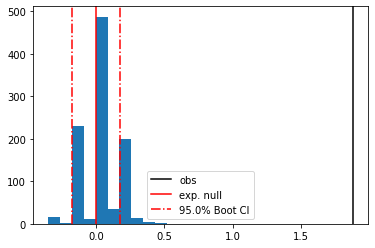

lower bound: -0.1727023565318877
expected   : 0.0
upper bound: 0.17587244162322513


In [21]:
# How about the 25th percentile?
stats, obs_stat = causal_inf.bootstrap(
    get_quantile_diff, verbose=True, q=0.25)

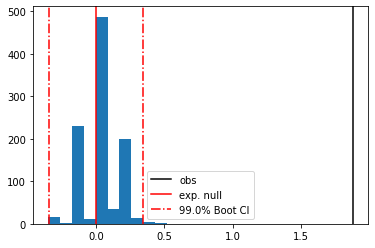

lower bound: -0.3424567874655377
expected   : 0.0
upper bound: 0.3424567874655377


In [22]:
# You can check a different interval for the last bootstrapping by 
# plotting the outputs with your new CI; e.g., what about the 99% CI?
causal_inf.plot_bootstrapped(stats, obs_stat, ci=0.99)

In [23]:
# NOTE though that by default the bootstrap only runs 1000 iterations,
# so the reliability of the CI becomes unstable as CI -> 1 (i.e., if you 
# want the 99.9% CI, probably better to do at least 10,000 iterations)

### Example 2: Continous Treatment Variable

In [24]:
causal_inf = CausalInference(data, 
                             response_var, 
                             treatment_var, 
                             covariates=covariates,
                             scaler=scaler)

In [25]:
causal_inf.treatment_type

'continuous'

In [26]:
causal_inf.get_propensity_scores(forward_folds=True)

Propensity scores not applicable to continous treatment. Go on to `get_iptw()` to get weights.



Shapiro-Wilk test for normality in "treatment"
p=0.00000; Deviates significantly from normality at alpha=0.05.
Model for mean value of treatment given covariates:
                                 OLS Regression Results                                
Dep. Variable:      bing_brand_clicks   R-squared (uncentered):                   0.066
Model:                            OLS   Adj. R-squared (uncentered):              0.064
Method:                 Least Squares   F-statistic:                              60.43
Date:                Mon, 12 Apr 2021   Prob (F-statistic):                    9.40e-38
Time:                        11:48:34   Log-Likelihood:                         -3584.5
No. Observations:                2588   AIC:                                      7175.
Df Residuals:                    2585   BIC:                                      7193.
Df Model:                           3                                                  
Covariance Type:            nonrobust       

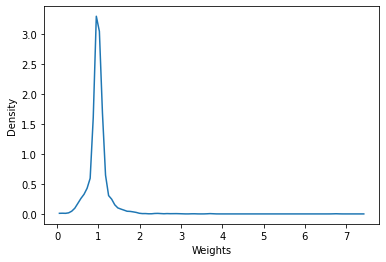

In [27]:
causal_inf.get_iptw(plot=True)

In [28]:
smd_table = causal_inf.assess_balance()
smd_table

Assessing balance between `treatment < median` and `treatment >= median`.


,mean_treat,mean_contr,smd,mean_treat_weighted,mean_contr_weighted,smd_weighted
tw_paid_engagements,0.059575,-0.062596,0.123818,0.011486,-0.042022,0.062306
ann_cost,0.029870,-0.031385,0.061216,-0.048280,0.092661,0.142969
organic_brand_clicks,0.074445,-0.078220,0.153448,0.044123,-0.141449,0.189988


In [29]:
causal_inf.run_msm(verbose=True)

                            WLS Regression Results                            
Dep. Variable:           new_accounts   R-squared:                       0.091
Model:                            WLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     260.4
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           6.97e-56
Time:                        11:52:19   Log-Likelihood:                -5925.9
No. Observations:                2588   AIC:                         1.186e+04
Df Residuals:                    2586   BIC:                         1.187e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             8.2047      0.04